# A Simple AutoEncoder
With autoencoders, we pass input data through an encoder that makes a compressed representation of the input. Then, this representation is passed through a decoder to reconstruct the input data. Generally the encoder and decoder will be built with neural networks, then trained on example data.

### Downloading MNIST Dataset

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Setting Data Loader Parameters and loading data in DataLoaders

In [2]:
BATCH_SIZE = 20
NUM_WORKERS = 0
INPUT_SIZE = 28
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

### Visualizing Data

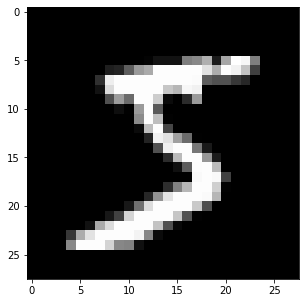

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

### Defining simple DNN
- The model takes (None, 28*28) sized flatten images and encoding dimension for hidden layer size

In [4]:
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self, encoding_dim):
        super(AutoEncoder, self).__init__()

        self.fc1 = nn.Linear(INPUT_SIZE * INPUT_SIZE, encoding_dim)
        
        self.fc2 = nn.Linear(encoding_dim, INPUT_SIZE * INPUT_SIZE)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))

        return x

In [5]:
ENCODING_DIM = 32
model = AutoEncoder(ENCODING_DIM)
print(model)

AutoEncoder(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=784, bias=True)
)


### Defining the loss and optimization algorithm

In [6]:
# As we are dealing with pixel-wise loss when comparing output to input
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

### Training the model and calculating loss

In [7]:
n_epochs = 20
for epoch in range(1, n_epochs + 1):
    training_loss = 0.0
    steps_per_epoch = 0
    # We don't care about labels right now
    for X,_ in train_loader:
        # Flatten with getting X.size(0) for batch size (20 in this case)
        X =  X.view(X.size(0), -1)
        # Clear the gradients for previous mini-batches
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, X)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        steps_per_epoch += 1
    else:
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, training_loss/steps_per_epoch))

Epoch: 1 	Training Loss: 0.032203
Epoch: 2 	Training Loss: 0.016671
Epoch: 3 	Training Loss: 0.014061
Epoch: 4 	Training Loss: 0.013570
Epoch: 5 	Training Loss: 0.013410
Epoch: 6 	Training Loss: 0.013313
Epoch: 7 	Training Loss: 0.013243
Epoch: 8 	Training Loss: 0.013189
Epoch: 9 	Training Loss: 0.013146
Epoch: 10 	Training Loss: 0.013110
Epoch: 11 	Training Loss: 0.013079
Epoch: 12 	Training Loss: 0.013051
Epoch: 13 	Training Loss: 0.013025
Epoch: 14 	Training Loss: 0.013002
Epoch: 15 	Training Loss: 0.012979
Epoch: 16 	Training Loss: 0.012959
Epoch: 17 	Training Loss: 0.012940
Epoch: 18 	Training Loss: 0.012921
Epoch: 19 	Training Loss: 0.012905
Epoch: 20 	Training Loss: 0.012890


### Testing the quality of encoding, given test images

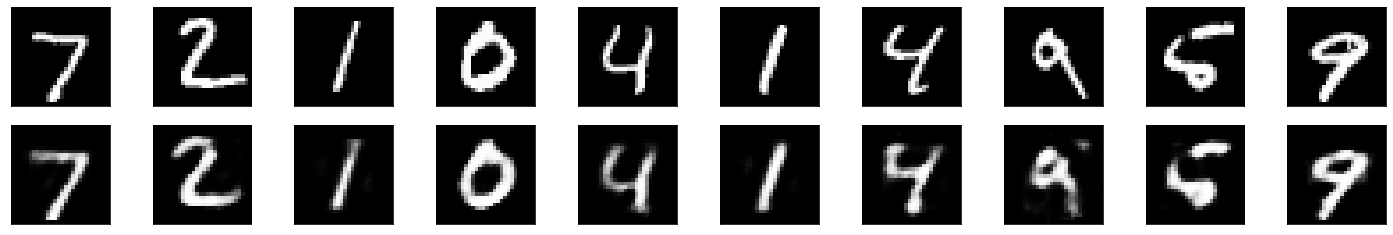

In [8]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)
output = model(images_flatten)
images = images.numpy()
output = output.view(BATCH_SIZE, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

**Results**: Encoding is quite good except for some blurriness in some parts

# AutoEncoding using Upsampling and Convolution Layers

- As we are dealing with images, it's better to use convolutions to autoencode them.
- To reduce dimensions we will use max-pool + conv2d in encoder and to increase back to original size we will use upsampling using nearest-neighbour technique + conv2d

In [51]:
Encoder = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2,stride=2),
                        nn.Conv2d(in_channels=16, out_channels=4, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2,stride=2),
                        ) # encode (None, 1, 28, 28) images to (None, 4, 7, 7)
print(Encoder)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [52]:
Decoder = nn.Sequential(nn.Upsample(scale_factor=2, mode='nearest'),
                        nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1),
                        nn.ReLU(),
                        nn.Upsample(scale_factor=2, mode='nearest'),
                        nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1),
                        nn.Sigmoid(),
                        )
print(Decoder)

Sequential(
  (0): Upsample(scale_factor=2.0, mode=nearest)
  (1): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): ReLU()
  (3): Upsample(scale_factor=2.0, mode=nearest)
  (4): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Sigmoid()
)


In [71]:
model = nn.Sequential(Encoder, Decoder)

In [64]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [67]:
n_epochs = 5
for epoch in range(1, n_epochs + 1):
    training_loss = 0.0
    steps_per_epoch = 0
    # We don't care about labels right now
    for X,_ in train_loader:
        # Clear the gradients for previous mini-batches
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, X)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        steps_per_epoch += 1
    else:
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, training_loss/steps_per_epoch))

Epoch: 1 	Training Loss: 0.007905
Epoch: 2 	Training Loss: 0.007408
Epoch: 3 	Training Loss: 0.007089
Epoch: 4 	Training Loss: 0.006867
Epoch: 5 	Training Loss: 0.006703


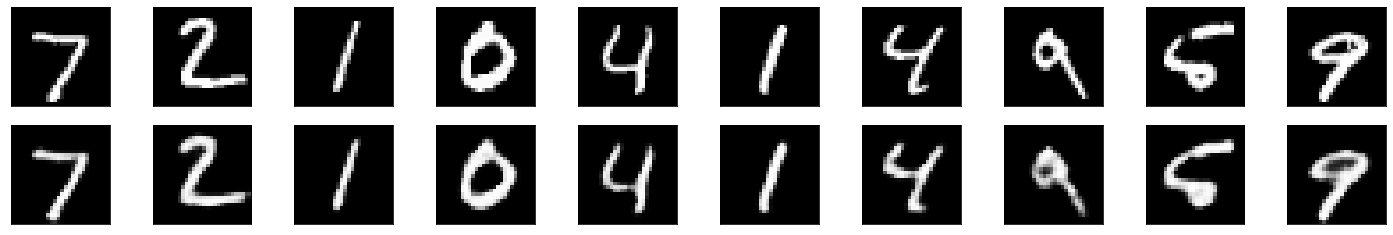

In [69]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

output = model(images)
images = images.numpy()
output = output.view(BATCH_SIZE, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# AutoEncoding using Convolution and Deconvolution(Transpose Convolution)
- Convolution output size is given by ${Floor\left(\frac{W + 2P - K}{S}\right) + 1}$

- Deconvolution output size is given by ${(W - 1)*S + K - 2P}$

In [70]:
# Encoder remains same as in Upsampling
Decoder = nn.Sequential(nn.ConvTranspose2d(in_channels=4, out_channels=16, kernel_size=2, stride=2),
                        nn.ReLU(),
                        nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, stride=2),
                        nn.Sigmoid(),
                        )
print(Decoder)

Sequential(
  (0): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (1): ReLU()
  (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
  (3): Sigmoid()
)


In [72]:
model = nn.Sequential(Encoder, Decoder)

In [73]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [74]:
n_epochs = 5
for epoch in range(1, n_epochs + 1):
    training_loss = 0.0
    steps_per_epoch = 0
    # We don't care about labels right now
    for X,_ in train_loader:
        # Clear the gradients for previous mini-batches
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, X)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        steps_per_epoch += 1
    else:
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, training_loss/steps_per_epoch))

Epoch: 1 	Training Loss: 0.025274
Epoch: 2 	Training Loss: 0.014546
Epoch: 3 	Training Loss: 0.013244
Epoch: 4 	Training Loss: 0.012645
Epoch: 5 	Training Loss: 0.012220


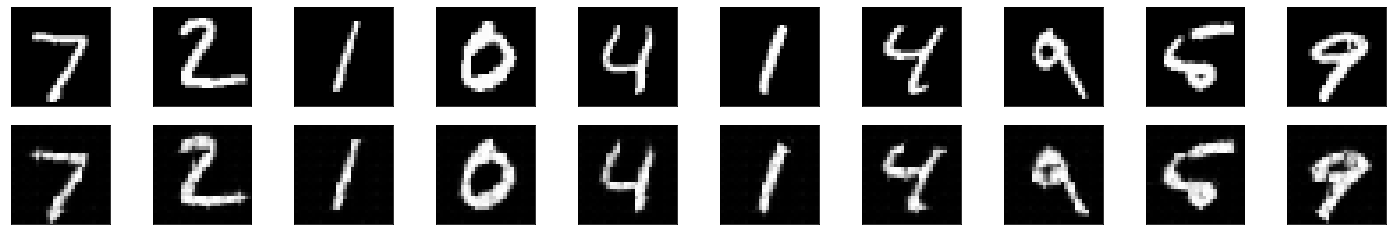

In [75]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

output = model(images)
images = images.numpy()
output = output.view(BATCH_SIZE, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)